# Building a simple neural-network with Keras

**Author: Fabian Witt**

This is a simple quick-start in performing digit recognition in a neural network in Keras, for a short tutorial at the University of Toronto. It is largely based on the mnist_mlp.py example from the Keras source.

## Time to build a neural network!
First let's import some prerequisites

In [1]:
import numpy as np
np.random.seed(1337)  # for reproducibility
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,8) # Make the figures a bit bigger

from keras.callbacks import TensorBoard
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils

Using TensorFlow backend.


## Load training data

In [2]:
batch_size = 128
nb_classes = 10
nb_epoch = 1

In [3]:
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

X_train original shape (60000, 28, 28)
y_train original shape (60000,)


Let's look at some examples of the training data

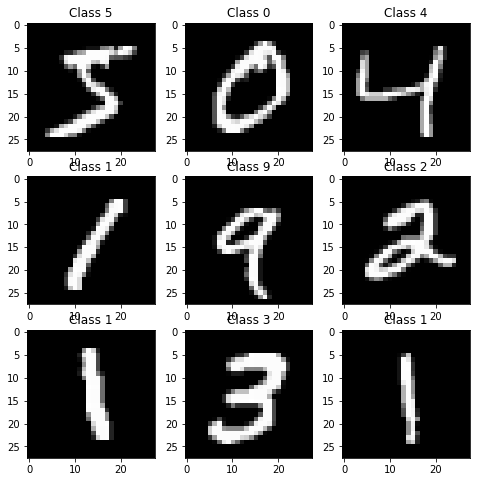

In [4]:
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[i]))

## Format the data for training
ur neural-network is going to take a single vector for each training example, so we need to reshape the input so that each 28x28 image becomes a single 784 dimensional vector. We'll also scale the inputs to be in the range [0-1] rather than [0-255]

In [5]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [6]:
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


Modify the target matrices to be in the one-hot format, i.e.  
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]  
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]  
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]  
etc.

In [7]:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

## Build the neural network
Build the neural-network. Here we'll do a simple 3 layer fully connected network.
![figure.png](attachment:figure.png)

* An "activation" is just a non-linear function applied to the output of the layer above. Here, with a "rectified linear unit", we clamp all values below 0 to 0.

* Dropout helps protect the model from memorizing or "overfitting" the training data

* This special "softmax" activation among other things, ensures the output is a valid probaility distribution, that is that its values are all non-negative and sum to 1.

In [8]:
model = Sequential()
model.add(Dense(512, input_dim=784, kernel_initializer='uniform'))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512, kernel_initializer='uniform'))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10, kernel_initializer='uniform'))
model.add(Activation('softmax'))

In [9]:
# prints a summary representation of the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
__________

## Compile the model
Keras is built on top of Theano (and now TensorFlow as well), both packages that allow you to define a computation graph in Python, which they then compile and run efficiently on the CPU or GPU without the overhead of the Python interpreter.

When compiing a model, Keras asks you to specify your **loss function** and your **optimizer**. The loss function we'll use here is called categorical crossentropy, and is a loss function well-suited to comparing two probability distributions.

Here our predictions are probability distributions across the ten different digits (e.g. "we're 80% confident this image is a 3, 10% sure it's an 8, 5% it's a 2, etc."), and the target is a probability distribution with 100% for the correct category, and 0 for everything else. The cross-entropy is a measure of how different your predicted distribution is from the target distribution. [More detail at Wikipedia](https://en.wikipedia.org/wiki/Cross_entropy)

The optimizer helps determine how quickly the model learns, how resistent it is to getting "stuck" or "blowing up". We won't discuss this in too much detail, but "adam" is often a good choice (developed here at U of T).

In [10]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the model!
This is the fun part: you can feed the training data loaded in earlier into this model and it will learn to classify digits

In [11]:
history = model.fit(X_train, Y_train,
                    batch_size=batch_size, epochs=nb_epoch,
                    callbacks=[TensorBoard(write_graph=True, write_images=True, histogram_freq=1)],
                    verbose=1, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 41s - loss: 0.2719 - acc: 0.9199 - val_loss: 0.1172 - val_acc: 0.9627


## Evaluate its performance

In [12]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.117204269655
Test accuracy: 0.9627


## Finally, save the model

In [13]:
# serialize model to JSON
model_json = model.to_json()
with open("model/model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("model/model.h5")

## Inspecting the output
It's always a good idea to inspect the output and make sure everything looks sane. Here we'll look at some examples it gets right, and some examples it gets wrong.

In [14]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes = model.predict_classes(X_test)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

 9856/10000 [============================>.] - ETA: 0s

### Correct

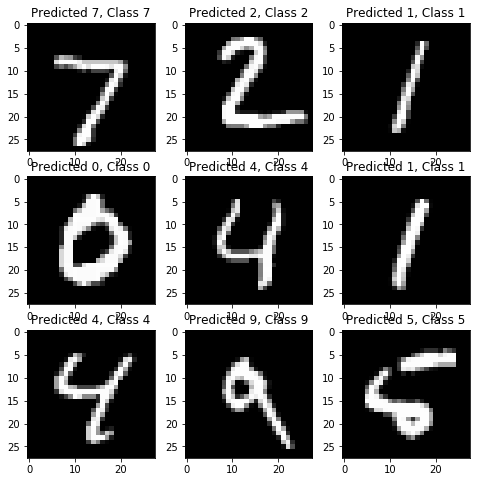

In [15]:
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))

### Incorrect

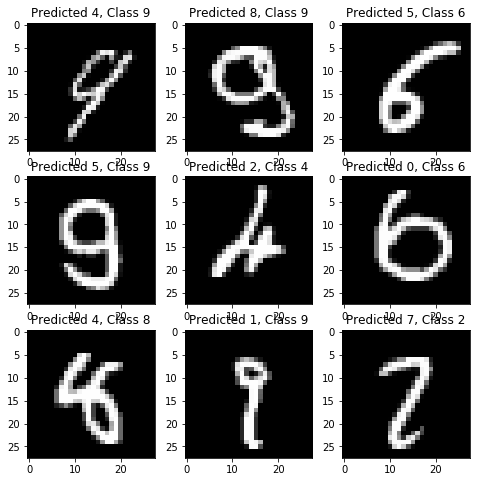

In [16]:
plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))

## Tensorboard

**TensorBoard** is a visualization tool, devoted to analyzing Data Flow Graph and also to better understand the machine learning models.  

It can view different types of statistics about the parameters and details of any part of a computer graph graphically. It often happens that a graph of computation can be very complex.

## Tensorboard Example

Run the **TensorBoard** Server:

**Important: The conda environment must be activated!**

```shell
tensorboard --logdir=/tmp/tf_logs
```

[Open TensorBoard](http://localhost:6006)

## That's all!